In [1]:
#https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
import numpy as np
from numpy import concatenate
from math import sqrt
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, LSTM
from keras.regularizers import l2

Using TensorFlow backend.


In [2]:
# convert series to supervised learning & normalize input variables
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [3]:
def data_preparation(df):
    # Get names of indexes for which column temporarily_unable_test has value 1000
    index = df[ df['number_busy'] > 2000 ].index
    # Delete these row indexes from dataFrame
    df.drop(index , inplace=True)
    
    # Get names of indexes for which column temporarily_unable_test has value 1000
    index = df[ df['temporarily_unable_test'] > 1000 ].index
    # Delete these row indexes from dataFrame
    df.drop(index , inplace=True)
    
    # Use a log transformation to decrease the impact of extreme values in column followup_tests
    df['followup_tests'] = np.log(df['followup_tests'] + 1)
    
    # Get names of indexes for which column outage_hrs has value > 300 
    index = df[ df['quality_too_poor'] > 300 ].index
    # Delete these row indexes from dataFrame
    df.drop(index , inplace=True)
    
    # Use a log transformation to decrease the impact of extreme values in column followup_tests
    df['outage_hrs'] = np.log(df['outage_hrs'])
    
    # Use a log transformation to decrease the impact of extreme values in column followup_tests
    df['numbers_tested'] = np.log(df['numbers_tested'])
    
    #df.drop(['followup_tests','outage_hrs', 'numbers_tested'], inplace=True, axis=1)
    
    return df

In [4]:
# load dataset
df = read_csv('../reports/company_report_2.csv', header=0, index_col="time")
#df = data_preparation(df)
df = df[['volume_tests', 'date', 'month', 'is_weekend', 'quality_too_poor', 'number_busy', 'temporarily_unable_test', 'outage_hrs', 'number_test_types', 'numbers_tested', 'min_commit']]
df = df.dropna(axis='columns')
values = df.values

# specify the number of days and features 
n_days = 7
n_features = df.shape[1]

# # integer encode direction
# encoder = LabelEncoder()
# values[:,2] = encoder.fit_transform(values[:,2])

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, n_days, 1)
print(reframed.shape)

(1187, 88)


In [5]:
# split into train and test sets
values = reframed.values

train_size = int(len(values) * 0.80)
test_size = len(values) - train_size
train, test = values[:train_size,:], values[train_size:,:]

# split into input and outputs
n_obs = n_days * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(949, 77) 949 (949,)
(949, 7, 11) (949,) (238, 7, 11) (238,)


Train on 949 samples, validate on 238 samples
Epoch 1/100
949/949 - 7s - loss: 2.7510 - accuracy: 0.0011 - val_loss: 2.5017 - val_accuracy: 0.0000e+00
Epoch 2/100
949/949 - 0s - loss: 2.3257 - accuracy: 0.0011 - val_loss: 2.1485 - val_accuracy: 0.0000e+00
Epoch 3/100
949/949 - 0s - loss: 2.0212 - accuracy: 0.0011 - val_loss: 1.9032 - val_accuracy: 0.0000e+00
Epoch 4/100
949/949 - 0s - loss: 1.8042 - accuracy: 0.0011 - val_loss: 1.7254 - val_accuracy: 0.0000e+00
Epoch 5/100
949/949 - 0s - loss: 1.6467 - accuracy: 0.0011 - val_loss: 1.5946 - val_accuracy: 0.0000e+00
Epoch 6/100
949/949 - 0s - loss: 1.5305 - accuracy: 0.0011 - val_loss: 1.4989 - val_accuracy: 0.0000e+00
Epoch 7/100
949/949 - 0s - loss: 1.4435 - accuracy: 0.0011 - val_loss: 1.4262 - val_accuracy: 0.0000e+00
Epoch 8/100
949/949 - 1s - loss: 1.3767 - accuracy: 0.0011 - val_loss: 1.3693 - val_accuracy: 0.0000e+00
Epoch 9/100
949/949 - 0s - loss: 1.3236 - accuracy: 0.0011 - val_loss: 1.3231 - val_accuracy: 0.0000e+00
Epoch 10/

Epoch 78/100
949/949 - 0s - loss: 0.3479 - accuracy: 0.0011 - val_loss: 0.3917 - val_accuracy: 0.0000e+00
Epoch 79/100
949/949 - 0s - loss: 0.3429 - accuracy: 0.0011 - val_loss: 0.3856 - val_accuracy: 0.0000e+00
Epoch 80/100
949/949 - 0s - loss: 0.3365 - accuracy: 0.0011 - val_loss: 0.3815 - val_accuracy: 0.0000e+00
Epoch 81/100
949/949 - 0s - loss: 0.3322 - accuracy: 0.0011 - val_loss: 0.3751 - val_accuracy: 0.0000e+00
Epoch 82/100
949/949 - 0s - loss: 0.3264 - accuracy: 0.0011 - val_loss: 0.3688 - val_accuracy: 0.0000e+00
Epoch 83/100
949/949 - 0s - loss: 0.3205 - accuracy: 0.0011 - val_loss: 0.3658 - val_accuracy: 0.0000e+00
Epoch 84/100
949/949 - 0s - loss: 0.3171 - accuracy: 0.0011 - val_loss: 0.3587 - val_accuracy: 0.0000e+00
Epoch 85/100
949/949 - 0s - loss: 0.3103 - accuracy: 0.0011 - val_loss: 0.3563 - val_accuracy: 0.0000e+00
Epoch 86/100
949/949 - 0s - loss: 0.3075 - accuracy: 0.0011 - val_loss: 0.3499 - val_accuracy: 0.0000e+00
Epoch 87/100
949/949 - 0s - loss: 0.3011 - acc

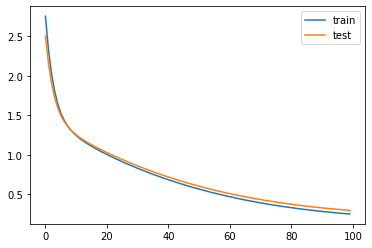

In [6]:
# design LSTM Model
model = Sequential()

model.add(LSTM(128, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01), input_shape=(train_X.shape[1], train_X.shape[2])))
#model.add(LSTM(32, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(Dropout(0.1))
model.add(Dense(1, kernel_initializer='lecun_uniform', activation='hard_sigmoid'))
optimizer = Adam(lr=0.001)
model.compile(loss='mae', optimizer=optimizer, metrics=['accuracy'])

# fit Model
history = model.fit(train_X, train_y, epochs=100, batch_size=100, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# plot loss history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [7]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_days*n_features))

# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -(n_features-1):]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -(n_features-1):]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 11845.182


In [8]:
# Score model
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))
score = model.evaluate(test_X, test_y, verbose=0)
print('Test loss:%.2f%%' % (score[0] * 100))
print('Test accuracy:%.2f%%' % (score[1] * 100))

Test loss:29.60%
Test accuracy:0.00%


In [9]:
# print predicted vs expected
num_days = 210
accuracy_scores = []
for i in range(len(inv_y[:num_days])):
    if inv_y[i] > inv_yhat[i]:
        score = inv_yhat[i] / inv_y[i] * 100
        accuracy_scores.append(score)
    else:
        score = inv_y[i] / inv_yhat[i] * 100
        accuracy_scores.append(score)
    print('Day=%d, Expected=%.2f, Predicted=%.2f, Accuracy=%.2f%%' % (i+1, inv_y[i], inv_yhat[i], score ))
print("%.2f%% (+/- %.2f%%)" % (np.mean(accuracy_scores), np.std(accuracy_scores)))

Day=1, Expected=52543.00, Predicted=45486.93, Accuracy=86.57%
Day=2, Expected=50885.00, Predicted=45463.18, Accuracy=89.34%
Day=3, Expected=24961.00, Predicted=45308.56, Accuracy=55.09%
Day=4, Expected=26332.00, Predicted=44911.71, Accuracy=58.63%
Day=5, Expected=51884.00, Predicted=44810.34, Accuracy=86.37%
Day=6, Expected=52157.00, Predicted=44951.25, Accuracy=86.18%
Day=7, Expected=51995.00, Predicted=45054.93, Accuracy=86.65%
Day=8, Expected=52428.00, Predicted=45069.44, Accuracy=85.96%
Day=9, Expected=50566.00, Predicted=45097.70, Accuracy=89.19%
Day=10, Expected=25610.00, Predicted=44928.67, Accuracy=57.00%
Day=11, Expected=26822.00, Predicted=44598.38, Accuracy=60.14%
Day=12, Expected=52320.00, Predicted=44522.18, Accuracy=85.10%
Day=13, Expected=53457.00, Predicted=44730.89, Accuracy=83.68%
Day=14, Expected=53142.00, Predicted=44897.38, Accuracy=84.49%
Day=15, Expected=53303.00, Predicted=44962.98, Accuracy=84.35%
Day=16, Expected=50991.00, Predicted=45013.70, Accuracy=88.28%
D

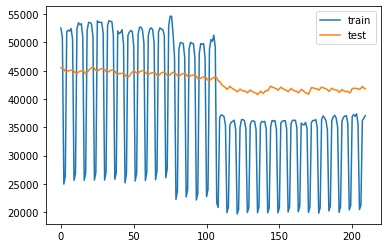

In [10]:
# plot actual vs prediction
num_days = 210
pyplot.plot(list(inv_y[:num_days]), label='train')
pyplot.plot(inv_yhat[:num_days], label='test')
pyplot.legend()
pyplot.show()